# Predicting length of stay at the Sonoma Animal Shelter

## Part 1: Data preparation



How long is a dog likely to stay at the Sonoma Animal Shelter?  It could be useful for the shelter to know this at the time the dog arrives at the shelter.  Is age an important factor?  What about size? Will linear regression be effective in predicting a dog's length of stay? 

In this notebook we perform the data preprocessing that will needed before using linear regression.

### Instructions:
* please read the entire notebook carefully
* problems for you to insert code are indicated with lines that begin with #@ followed by a problem number
* do not modify any code except in the problem cells

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [2]:
# switch to seaborn default stylistic parameters
sns.set()
sns.set_context('notebook') 
sns.set_style('whitegrid')

### Read the data

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/grbruns/cst383/master/sonoma-shelter-12-2022.csv")

We immediately drop all rows for which the animal type is not "DOG".  Once we have done that, we no longer need the 'Type' variable.

In [4]:
df = df[df['Type'] == 'DOG']
df.drop('Type', axis=1, inplace=True)

Also, the 'Intake Date' and 'Date of Birth' variables are converted to Pandas timestamp type.

In [5]:
df['Intake Date'] = pd.to_datetime(df['Intake Date'])
df['Date Of Birth'] = pd.to_datetime(df['Date Of Birth'])

df.set_index('Intake Date', inplace=True)
df.sort_index(inplace=True)

### Preliminary exploration

Look at the size of the data set, the variables included, and the amount of missing data.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12454 entries, 2013-08-22 to 2021-11-29
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Name                  11237 non-null  object        
 1   Breed                 12454 non-null  object        
 2   Color                 12454 non-null  object        
 3   Sex                   12454 non-null  object        
 4   Size                  12423 non-null  object        
 5   Date Of Birth         10377 non-null  datetime64[ns]
 6   Impound Number        12454 non-null  object        
 7   Kennel Number         12451 non-null  object        
 8   Animal ID             12454 non-null  object        
 9   Outcome Date          12379 non-null  object        
 10  Days in Shelter       12454 non-null  int64         
 11  Intake Type           12454 non-null  object        
 12  Intake Subtype        12454 non-null  object        
 13 

There is not a lot of missing data, but the date of birth is missing in more than 15% of the rows.  This makes sense, since some animals are probably strays with no identifying information.

It appears that many of the variables are categorical.  To help confirm the variable types, we can look at the number of unique values in each column.

In [7]:
#@ 1  Write an expression that will give the number of unique values in each column of dataframe df.

df.nunique()

Name                     4259
Breed                     803
Color                     197
Sex                         5
Size                        6
Date Of Birth            4301
Impound Number          12454
Kennel Number             146
Animal ID               10613
Outcome Date             2250
Days in Shelter           240
Intake Type                 7
Intake Subtype             28
Outcome Type                9
Outcome Subtype           192
Intake Condition            5
Outcome Condition           6
Intake Jurisdiction        13
Outcome Jurisdiction       12
Outcome Zip Code          568
Location                  568
Count                       2
dtype: int64

What is the distribution of the number of days a dog stays in the shelter?

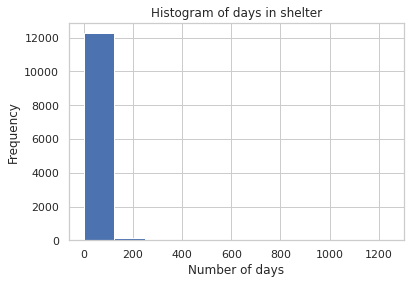

In [8]:
df['Days in Shelter'].plot.hist().set_title('Histogram of days in shelter')
plt.xlabel('Number of days');

It appears that many stay for a small number of days, and very few stay for months or even years.  Plotting using a log function can help in visualizing the distribution.

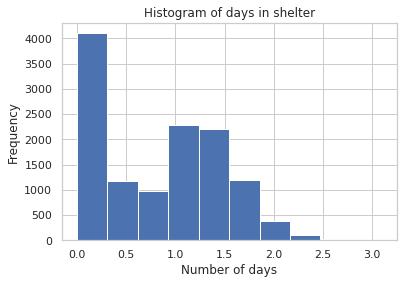

In [9]:
# 1 is added because log(0) is negative infinity.
np.log10(df['Days in Shelter']+1).plot.hist().set_title('Histogram of days in shelter')
plt.xlabel('Number of days');

What is the distribution of intake type and outcome type?

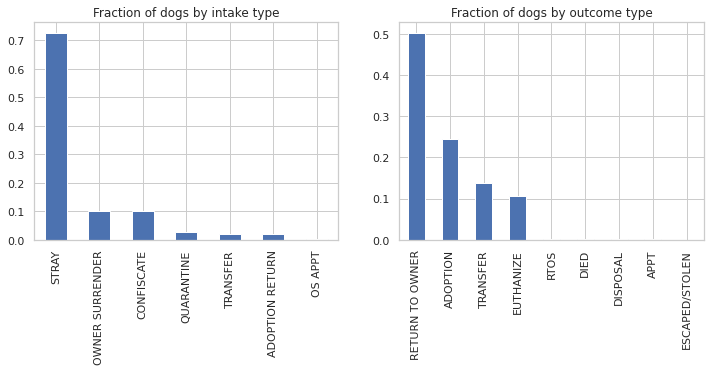

In [10]:
fig,ax = plt.subplots(1, 2, figsize=(12, 4))
df['Intake Type'].value_counts(normalize=True).plot.bar(ax=ax[0]).set_title('Fraction of dogs by intake type')
df['Outcome Type'].value_counts(normalize=True).plot.bar(ax=ax[1]).set_title('Fraction of dogs by outcome type');

By far, most dogs enter the shelter as strays.  Interestingly, about half the dogs leave by being returned to owner.  Less than a quarter of the dogs that enter are adopted.  Sadly, about 1 in 10 dogs that enter the shelter are euthanized.

Many dogs breeds are represented in the data set.  Which dog breeds enter the shelter the most?

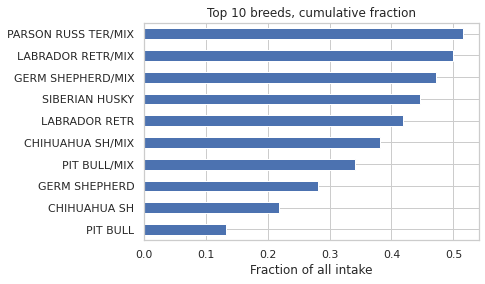

In [11]:
#@ 2  Plot the cumulative fraction of dogs by breed
# Plot only the top 10 breeds.
# Use a horizontal barplot.
#
# hint: use the 'normalize' option of value_counts()
# hint: use the method cumsum() of Pandas

df['Breed'].value_counts(normalize=True).cumsum()[:10].plot.barh()
plt.title('Top 10 breeds, cumulative fraction')
plt.xlabel('Fraction of all intake'); 


There are many intake subtypes.  What are they, and do a few of the intake subtypes dominate?

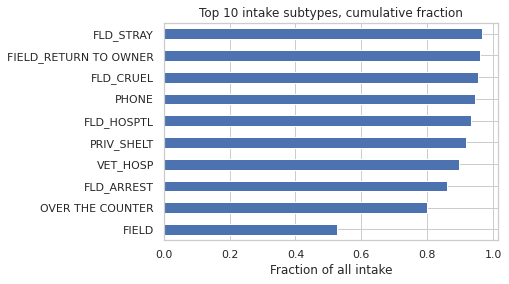

In [12]:
#@ 3  Plot the cumulative fraction of dogs intake subtype
# Plot only the top 10 intake substypes.
# Use a horizontal barplot.

df['Intake Subtype'].value_counts(normalize=True).cumsum()[:10].plot.barh()
plt.title('Top 10 intake subtypes, cumulative fraction')
plt.xlabel('Fraction of all intake');

Yes, the top few subtypes account for most of the data.  The first five intake subtypes account for more than 90% of the data.

We are interesting in predicting how long a dog will stay in the shelter.  Does the intake type appear to be relevant?

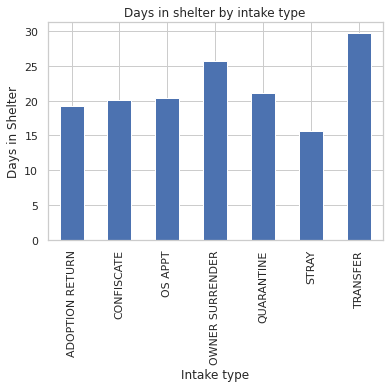

In [13]:
#@ 4  Plot the average number of days for each intake type.
# Hint: when you see problems like this, you should think "group by"
# Hint: Pandas plotting is convenient here


df.groupby('Intake Type')['Days in Shelter'].mean().plot.bar()
plt.title('Days in shelter by intake type')
plt.xlabel('Intake type')
plt.ylabel('Days in Shelter');
 


On average, strays appear to spend less time in the shelter, and dogs that have been transferred to the shelter appear to spend more time in the shelter.

### Data preprocessing

Drop all variables related to outcome, because we want to predict length of stay from variables that are known at the time the animal arrives at the shelter.

The 'Location' variable is related to the outcome, according to the data dictionary.

In [14]:
df.drop(['Outcome Date', 'Outcome Type', 'Outcome Subtype', 'Outcome Condition', 'Outcome Jurisdiction', 'Outcome Zip Code', 'Location'], 
        axis=1, inplace=True)

Drop additional variables we know that we will not want to use.

In [15]:
df.drop(['Name', 'Impound Number', 'Kennel Number', 'Animal ID', 'Intake Jurisdiction', 'Count'], 
        axis=1, inplace=True)

There are many color values, and their relationships are complicated, so we drop the color variable.

In [16]:
df.drop(['Color'], axis=1, inplace=True)

The income type "OS APPT" hardly ever appears, so it is dropped.

In [17]:
#@ 5  Write a statement to remove all rows of df in which the intake type is "OS APPT"
# Hint: it is easy to do this with a mask and a simple assignment statement.

df = df[df['Intake Type'] != "OS APPT"]


In [18]:
df['Intake Type'].value_counts()

STRAY              9046
OWNER SURRENDER    1272
CONFISCATE         1252
QUARANTINE          342
TRANSFER            259
ADOPTION RETURN     255
Name: Intake Type, dtype: int64

We want to use the dogs's age as a predictor variable.  The age can be computed from 'Intake Date' and 'Date of Birth', but there are many missing values in the 'Date of Birth' variable.

Our approach will be to add a new column showing whether the date of birth was missing, and then to impute the missing age values.  The date of birth variable is then removed.

In [19]:
# The new Age variable is in units of years
df['Unknown DOB'] = df['Date Of Birth'].isna()
df['Age'] = (df.index - df['Date Of Birth'])/np.timedelta64(1, 'Y')
df.drop('Date Of Birth', axis=1, inplace=True)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12426 entries, 2013-08-22 to 2021-11-29
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Breed             12426 non-null  object 
 1   Sex               12426 non-null  object 
 2   Size              12395 non-null  object 
 3   Days in Shelter   12426 non-null  int64  
 4   Intake Type       12426 non-null  object 
 5   Intake Subtype    12426 non-null  object 
 6   Intake Condition  12426 non-null  object 
 7   Unknown DOB       12426 non-null  bool   
 8   Age               10351 non-null  float64
dtypes: bool(1), float64(1), int64(1), object(6)
memory usage: 885.8+ KB


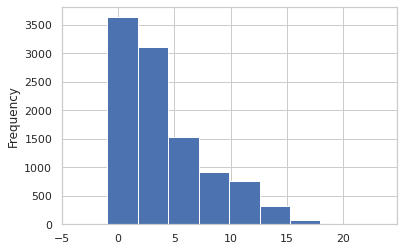

In [21]:
df['Age'].plot.hist();

The age histogram shows that some ages are negative.  Are there a significant number of negative values?

In [22]:
#@ 6  Print the number of negative age values.

print("Number of negative age values:",(df["Age"]<0).sum())


Number of negative age values: 10


Very few rows have negative age, so they can be dropped.

In [23]:
df = df[df['Age'] >= 0.0 ]

Impute the missing age values using the median.

In [24]:
#@ 7  Write a statement to replace all NA values of column 'Age' with the median age value.
# Hint: Pandas has a median() method on series objects.


df['Age'].fillna(df['Age'].median(), inplace=True)


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


Add a new variable showing length of stay in log 10.  This will become our predictor variable.

In [25]:
df['Log Days in Shelter'] = np.log10(df['Days in Shelter'] + 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Now there is little missing data, so rows with missing data are dropped.

In [26]:
print('Total count of missing values: {}'.format(df.isna().sum().sum()))

Total count of missing values: 23


In [27]:
df.dropna(inplace=True)

### Data exploration

Here is an overview of the data after preprocessing.

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10318 entries, 2013-08-22 to 2021-11-29
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Breed                10318 non-null  object 
 1   Sex                  10318 non-null  object 
 2   Size                 10318 non-null  object 
 3   Days in Shelter      10318 non-null  int64  
 4   Intake Type          10318 non-null  object 
 5   Intake Subtype       10318 non-null  object 
 6   Intake Condition     10318 non-null  object 
 7   Unknown DOB          10318 non-null  bool   
 8   Age                  10318 non-null  float64
 9   Log Days in Shelter  10318 non-null  float64
dtypes: bool(1), float64(2), int64(1), object(6)
memory usage: 816.2+ KB


Visualize the relationship between a dog's age and the new predictor variable.

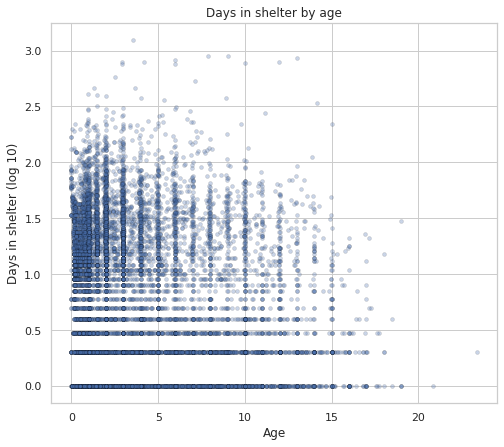

In [29]:
plt.figure(figsize=(8,7))
sns.scatterplot(x='Age', y='Log Days in Shelter', data=df, alpha=0.3, s=15, edgecolor='black').set_title('Days in shelter by age');
plt.ylabel('Days in shelter (log 10)');

It is not easy to tell, but it appears that older dogs tend to spend less time in the shelter.  Perhaps older dogs are more often in poor health and are eventually euthanized.  It appears that many dogs are less than 2 years old and stay for about 1-4 weeks.

### Machine learning

First we need to do additional data preprocessing to support machine learning.  We need to encode the categorical variables according to their type.  An issue is that there are many intake subtypes and many breeds.

In [30]:
df.nunique()

Breed                   753
Sex                       5
Size                      6
Days in Shelter         234
Intake Type               6
Intake Subtype           27
Intake Condition          5
Unknown DOB               1
Age                    3075
Log Days in Shelter     234
dtype: int64

Many of the intake subtype values rarely appear, so we will keep the top five values only, and replace all other values with 'OTHER'.  Similarly, we will keep only the top 10 values of breed.

In [31]:
top_subtypes = df['Intake Subtype'].value_counts().index[:5]
df.loc[~df['Intake Subtype'].isin(top_subtypes), 'Intake Subtype'] = 'OTHER'

There are many breeds, so we will keep the top ten values only, and replace all other values with 'OTHER'.

In [32]:
top_breeds = df['Breed'].value_counts().index[:10]
df.loc[~df['Breed'].isin(top_breeds), 'Breed'] = 'OTHER'

In [33]:
#@ 8  Write a statement to replace each of the categorical variables in df with dummy variables
# If there are 5 possible values of a categorical variable, create only 4 dummy variables.

#df1= df.copy()
#df1 = pd.get_dummies(df1,
                     #columns=['Breed','Sex','Size','Days in Shelter','Intake Type','Intake Subtype','Intake Condition','Unknown DOB','Age','Log Days in Shelter']) 
df = pd.get_dummies(data=df,drop_first = True)


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10318 entries, 2013-08-22 to 2021-11-29
Data columns (total 37 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Days in Shelter                        10318 non-null  int64  
 1   Unknown DOB                            10318 non-null  bool   
 2   Age                                    10318 non-null  float64
 3   Log Days in Shelter                    10318 non-null  float64
 4   Breed_CHIHUAHUA SH/MIX                 10318 non-null  uint8  
 5   Breed_GERM SHEPHERD                    10318 non-null  uint8  
 6   Breed_GERM SHEPHERD/MIX                10318 non-null  uint8  
 7   Breed_LABRADOR RETR                    10318 non-null  uint8  
 8   Breed_LABRADOR RETR/MIX                10318 non-null  uint8  
 9   Breed_OTHER                            10318 non-null  uint8  
 10  Breed_PARSON RUSS TER/MIX              10318 non-null

We are ready to prepare the NumPy arrays that are needed for machine learning.

In [35]:
#@ 9 Create NumPy arrays X and y
# X will be a 2D NumPy array containing values of all the predictor variables.
# The predictor variables are all columns of df except for 'Days in Shelter' and 'Log Days in Shelter'.
# y will be a 1D NumPy array contain the values of the target variable, which is 'Log Days in Shelter'.
# Hint: I recommend defining variables 'predictors' and 'target', and using them in defining X and y, like we do in class.

w1 = df.columns.values.tolist()
w1.remove('Days in Shelter')
w1.remove('Log Days in Shelter')
predictors=df[w1].columns.values.tolist()
targets=['Log Days in Shelter']
X=df[predictors]
y=df[targets]

What is the shape of the X and y arrays?

In [36]:
print(X.shape)
print(y.shape)

(10318, 35)
(10318, 1)
